# Convolutional neural networks from scratch

In [1]:
import mxnet as mx
import numpy as np
from mxnet import gluon
from tqdm import tqdm_notebook as tqdm
mx.random.seed(1)

## Context

In [2]:
ctx = mx.cpu()

## MNIST Dataset

In [3]:
batch_size = 64
num_inputs = 784
num_outputs = 10

In [4]:
def transform(data, label):
    return mx.nd.transpose(data=data.astype(np.float32), axes=(2, 0, 1)) / 255, label.astype(np.float32)

In [5]:
train_data = gluon.data.DataLoader(dataset=gluon.data.vision.MNIST(train=True, transform=transform),
                                   batch_size=batch_size,
                                   shuffle=True)
test_data = gluon.data.DataLoader(dataset=gluon.data.vision.MNIST(train=False, transform=transform),
                                  batch_size=batch_size,
                                  shuffle=False)

## Parameters

In [6]:
#######################
#  Set the scale for weight initialization and choose
#  the number of hidden units in the fully-connected layer
#######################
weight_scale = .01
num_fc = 128
num_filter_conv_layer1 = 20
num_filter_conv_layer2 = 50

W1 = mx.nd.random_normal(shape=(num_filter_conv_layer1, 1, 3,3),
                      scale=weight_scale,
                      ctx=ctx)
b1 = mx.nd.random_normal(shape=num_filter_conv_layer1,
                      scale=weight_scale,
                      ctx=ctx)

W2 = mx.nd.random_normal(shape=(num_filter_conv_layer2, num_filter_conv_layer1, 5, 5), 
                      scale=weight_scale,
                      ctx=ctx) 
b2 = mx.nd.random_normal(shape=num_filter_conv_layer2,
                      scale=weight_scale,
                      ctx=ctx)

W3 = mx.nd.random_normal(shape=(800, num_fc),
                      scale=weight_scale,
                      ctx=ctx)
b3 = mx.nd.random_normal(shape=num_fc,
                      scale=weight_scale,
                      ctx=ctx)

W4 = mx.nd.random_normal(shape=(num_fc, num_outputs),
                      scale=weight_scale,
                      ctx=ctx)
b4 = mx.nd.random_normal(shape=num_outputs,
                      scale=weight_scale,
                      ctx=ctx)

params = [W1, b1, W2, b2, W3, b3, W4, b4]

In [7]:
for param in params:
    param.attach_grad()

## Example of convolution

In [8]:
# Batch size = 64
# Number of filters = 20
# Height = 26, valid convolution
# Width = 26
for data, _ in train_data:
    data = data.as_in_context(ctx)
    break
conv = mx.nd.Convolution(data=data,
                         weight=W1,
                         bias=b1,
                         kernel=[3, 3],
                         num_filter=num_filter_conv_layer1)
print(conv.shape)

(64, 20, 26, 26)


In [9]:
conv_output_example = conv[0, 1, :, :].asnumpy()

In [10]:
data_example=data.asnumpy()

In [11]:
data_example = np.squeeze(data_example, axis=1)

In [12]:
data_example[0].shape

(28, 28)

In [13]:
conv_output_example.shape

(26, 26)

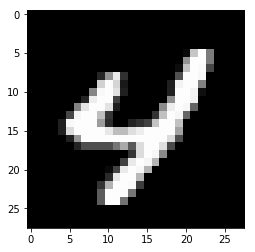

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(data_example[0], cmap='gray')

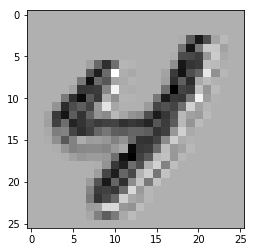

In [15]:
plt.imshow(conv_output_example, cmap='gray')

## Example of max pooling

In [16]:
pool = mx.nd.Pooling(data=conv,
                     pool_type="max",
                     kernel=(2,2),
                     stride=(2,2))

In [17]:
pool.shape

(64, 20, 13, 13)

In [18]:
pool[0][0].shape

(13, 13)

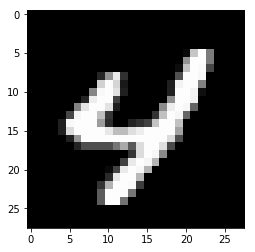

In [19]:
plt.imshow(data_example[0],
           cmap='gray')

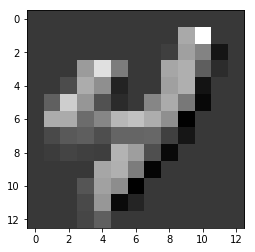

In [20]:
plt.imshow(pool[0][0].asnumpy(),
           cmap='gray')

## ReLU activation function

In [21]:
def relu(X):
    return mx.nd.maximum(X, mx.nd.zeros_like(X))

## Softmax Output

In [22]:
def softmax(y_linear):
    exp = mx.nd.exp(data=y_linear - mx.nd.max(y_linear))
    partition = mx.nd.sum(data=exp,
                          axis=0,
                          exclude=True).reshape((-1,1))
    return exp / partition

## Softmax Cross-entropy Loss

In [23]:
def softmax_cross_entropy(yhat_linear, y):
    return - mx.nd.nansum(y * mx.nd.log_softmax(data=yhat_linear),
                          axis=0,
                          exclude=True)

## Model

In [24]:
def net(X, debug=False):
    ########################
    #  Define the computation of the first convolutional layer
    ########################
    h1_conv = mx.nd.Convolution(data=X,
                                weight=W1,
                                bias=b1,
                                kernel=(3,3),
                                num_filter=num_filter_conv_layer1)
    h1_activation = relu(h1_conv)
    
    if debug:
        print("Layer h1 before pooling.") 
        print("Shape: %s" % (np.array(h1_activation.shape)))
        
    h1 = mx.nd.Pooling(data=h1_activation,
                       pool_type="avg",
                       kernel=(2,2),
                       stride=(2,2))
    if debug:
        print("Layer h2 after pooling.")
        print("Shape: %s" % (np.array(h1.shape)))

    ########################
    #  Define the computation of the second convolutional layer
    ########################
    h2_conv = mx.nd.Convolution(data=h1,
                                weight=W2,
                                bias=b2,
                                kernel=(5,5),
                                num_filter=num_filter_conv_layer2)
    h2_activation = relu(h2_conv)
    if debug:
        print("Layer h2 before pooling.")
        print("Shape: %s" % (np.array(h2_activation.shape)))
              
    h2 = mx.nd.Pooling(data=h2_activation,
                       pool_type="avg",
                       kernel=(2,2),
                       stride=(2,2))
    if debug:
        print("Layer h2 after pooling.")
        print("Shape: %s" % (np.array(h2.shape)))

    ########################
    #  Flattening h2 so that we can feed it into a fully-connected layer
    ########################
    h2 = mx.nd.flatten(h2)
    if debug:
        print("Flat layer h2.")
        print("Shape: %s" % (np.array(h2.shape)))

    ########################
    #  Define the computation of the third (fully-connected) layer
    ########################
    h3_linear = mx.nd.dot(h2, W3) + b3
    h3 = relu(h3_linear)
    if debug:
        print("Layer h3.")
        print("Shape: %s" % (np.array(h3.shape)))

    ########################
    #  Define the computation of the output layer
    ########################
    yhat_linear = mx.nd.dot(h3, W4) + b4
    if debug:
        print("yhat_linear shape: %s" % (np.array(yhat_linear.shape)))

    return yhat_linear

## Test run

In [25]:
output = net(data, debug=True)

Layer h1 before pooling.
Shape: [64 20 26 26]
Layer h2 after pooling.
Shape: [64 20 13 13]
Layer h2 before pooling.
Shape: [64 50  9  9]
Layer h2 after pooling.
Shape: [64 50  4  4]
Flat layer h2.
Shape: [ 64 800]
Layer h3.
Shape: [ 64 128]
yhat_linear shape: [64 10]


## Stochastic Gradient Descent

In [26]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [27]:
output.shape

(64, 10)

## Evaluation metric

In [28]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        label_one_hot = mx.nd.one_hot(label, 10)
        output = net(data)
        predictions = mx.nd.argmax(data=output,
                                   axis=1)
        numerator += mx.nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

## Training Loop

In [29]:
epochs = 1
learning_rate = .01
smoothing_constant = .01

for e in tqdm(range(epochs)):
    for i, (data, label) in tqdm(enumerate(train_data)):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        label_one_hot = mx.nd.one_hot(label, num_outputs)
        with mx.autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = mx.nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)


    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))

Epoch 0. Loss: 0.1547383428193869, Train_acc 0.96433336, Test_acc 0.9625

